# Reverberation Estimation Time Test


In [1]:
# Import Systems 
import struct
import io
import os
import sys
import time
import platform

# Import Audio
import pyaudio
import librosa
import soundfile

import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

# User Libraries
import pyOssWavfile
import pyOssFilter
import pyRoomAcoustic as room
import pyOssDebug as dbg
import pyroomacoustics as pyroom


In [2]:
###########################################################
# Load Impulse
###########################################################
imp_dir = 'ju_impulse'         # 임펄스 음원 파일이 있는 프로젝트 내 폴더명

# SET IMPULSE WAVE FILE NAME IN 'impulsefiles' DIRECTORY
# imp_name = "StairwayUniversityOfYork"

# IMPULSE WAVE FILE NAME IN 'ju_impulse' DIRECTORY
# imp_name = 'ju_imp_goyang_aramnuri_concerthall'
# imp_name = 'Impulse_201125_JU_SoundLab_Ori_mono_48k_32i'
# imp_name = 'Impulse_201125_JU_SoundLab_Aram_mono_48k_32i'
# imp_name = 'Impulse_201125_JU_SoundLab_Daegu_mono_48k_32i'
imp_name = 'Impulse_201125_JU_SoundLab_Sejong_mono_48k_32i'


# 파일명 조합
imp_fname = pyOssWavfile.str_fname(imp_dir, imp_name)

# Check Impulse Wav file header information
st_fmt_i = pyOssWavfile.extractWavFmtChunk( pyOssWavfile.read_format(imp_fname) )
dbg.dWavInfo(st_fmt_i)

# Load Original Audio & Convert format mono / float32 / 44.1kHz 
chunk_i, data_i, st_fmt_i, t_i = pyOssWavfile.readf32( imp_fname )
dbg.dWavInfo(st_fmt_i)          # for debug (print wav header)
print(f"Time(sec) =", t_i)


Audio Format = Int
Number of Channel = 1
Sampling Frequency = 48000
Bits per Sample = 16
Audio Format = float
Number of Channel = 1
Sampling Frequency = 44100
Bits per Sample = 32
Time(sec) = 5.461337868480726


0.032063492063492065


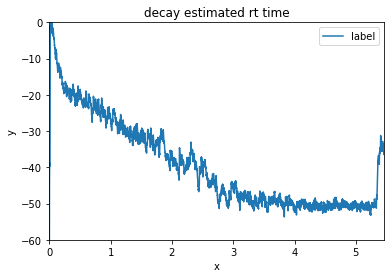

Label:  decay estimate rt
 - Decay Time  0 ~ -10dB =  0.08800000000000001
 - Decay Time -5 ~ -25dB =  1.008
 - Decay Time -5 ~ -35dB =  2.336
 - EDT =  0.528
 - T20 =  3.024
 - T30 =  4.672
 - RT60(=T30) =  4.672
 - D50 =  0.5732792803831765
 - C50 =  1.2822251493261785
 - C80 =  4.807276826099635
Label:  decay pyroom.sabine rt
 - Decay Time  0 ~ -10dB =  0.08800000000000001
 - Decay Time -5 ~ -25dB =  1.008
 - Decay Time -5 ~ -35dB =  2.336
 - EDT =  0.528
 - T20 =  3.024
 - T30 =  4.672
 - RT60(=T30) =  4.672
 - D50 =  0.5732792803831765
 - C50 =  1.2822251493261785
 - C80 =  4.807276826099635
Label:  decay pyroom.eyring rt
 - Decay Time  0 ~ -10dB =  0.08700000000000001
 - Decay Time -5 ~ -25dB =  0.977
 - Decay Time -5 ~ -35dB =  2.312
 - EDT =  0.522
 - T20 =  2.931
 - T30 =  4.624
 - RT60(=T30) =  4.624
 - D50 =  0.5732792803831765
 - C50 =  1.2822251493261785
 - C80 =  4.807276826099635


In [7]:
rm_width = 8.45     # JU SoundLab 가로길이
rm_depth = 7.61     #
rm_height = 2.64
alpha = 0.31        # JU SoundLab 추정 흡음률 (아트보드 9T NRC)

estimate_rt, V, S, K, A = room.rt60_sabine(rm_depth, rm_depth, rm_height, 20, w_absl=alpha)
sabine_rt = pyroom.acoustics.rt60_sabine(S, V, alpha, m=0, c=room.soundspeed(20))
eyring_rt = pyroom.acoustics.rt60_eyring(S, V, alpha, m=0, c=room.soundspeed(20))

fc = 500            # Octave Band at 500 Hz
# fc = 0              # No Filter
data_filt, decay, a_param = pyOssFilter.calc_filt_impulse(data_i, st_fmt_i.fs, fc, filt_type='fir', order_tab=1024, fname=imp_name)
decay_t_i_es = room.decayCurve(data_filt, estimate_rt, st_fmt_i.fs)
decay_t_i_sb = room.decayCurve(data_filt, sabine_rt, st_fmt_i.fs)
decay_t_i_ey = room.decayCurve(data_filt, eyring_rt, st_fmt_i.fs)

dbg.dPlotDecay(st_fmt_i.fs, decay_t_i_es, title_txt='decay estimated rt time')
# dbg.dAParam( data_filt, decay_t_i_es, st_fmt_i.fs, fname='decay estimate rt' )
# dbg.dAParam( data_filt, decay_t_i_sb, st_fmt_i.fs, fname='decay sabine rt' )
# dbg.dAParam( data_filt, decay_t_i_ey, st_fmt_i.fs, fname='decay eyring rt' )

room.calcAcousticParam( data_filt, decay_t_i_es, st_fmt_i.fs, printout=True, label_text='decay estimate rt' )
room.calcAcousticParam( data_filt, decay_t_i_sb, st_fmt_i.fs, printout=True, label_text='decay pyroom.sabine rt' )
room.calcAcousticParam( data_filt, decay_t_i_ey, st_fmt_i.fs, printout=True, label_text='decay pyroom.eyring rt' )


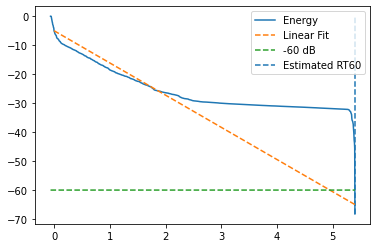

5.3979591836734695


In [4]:
rt = pyroom.experimental.rt60.measure_rt60(data_filt, st_fmt_i.fs, plot=True)
print(rt)